In [74]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from cartesian_explorer import Explorer
import qtensor as qt


In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from cartesian_explorer import caches
cache = caches.JobLibCache('.cache/diag_zz_plots')
ex = Explorer(cache=cache)

## Set up the functions

In [13]:
@ex.provider
def graph(n, d, seed, graph_type='random'):
    if graph_type=='grid':
        n = int(np.sqrt(n))
        return nx.grid_graph(dim=[n, n], periodic=True)
    else:
        return qt.toolbox.random_graph(nodes=n, degree=d, seed=seed)

@ex.provider
def circuit(graph, p, circuit_type, composer_type='ZZ', operators='diagonal', edge_idx=0):
    beta, gamma = [.1]*p, [.2]*p
    if composer_type=='ZZ':
        if operators=='full':
            comp = qt.ZZQtreeFullQAOAComposer(graph, beta=beta, gamma=gamma)
        else:
            comp = qt.ZZQtreeQAOAComposer(graph, beta=beta, gamma=gamma)
    if composer_type=='default':
        if operators=='full':
            comp = qt.QtreeFullQAOAComposer(graph, beta=beta, gamma=gamma)
        else:
            comp = qt.QtreeQAOAComposer(graph, beta=beta, gamma=gamma)
            
    if circuit_type == 'ansatz':
        comp.ansatz_state()
    if circuit_type == 'energy':
        comp.energy_expectation_lightcone(list(graph.edges())[edge_idx])
    return comp.circuit

In [5]:
@ex.provider
def circuit_sim_costs(circuit, ordering_algo='greedy'):
    tn = qt.optimisation.TensorNet.QtreeTensorNet.from_qtree_gates(circuit)
    if ordering_algo=='greedy':
        opt = qt.optimisation.Optimizer.DefaultOptimizer()
    elif 'tamaki' in ordering_algo:
        if '_' in ordering_algo:
            _, time_str = ordering_algo.split('_')
            wait_time=int(time_str)
        else:
            wait_time=15
        opt = qt.optimisation.Optimizer.TamakiOptimizer(wait_time=wait_time)
    peo, _ = opt.optimize(tn)
    costs, mems = tn.simulation_cost(peo)
    return tuple(costs), tuple(mems)

@ex.provider
def max_memory(circuit_sim_costs):
    costs, mems = circuit_sim_costs
    return max(mems)

@ex.provider
def sum_flops(circuit_sim_costs):
    costs, mems = circuit_sim_costs
    return sum(costs)

## Plot complexity graphs

In [39]:
plots_dir = '../data/figures/diagonal_zz_paper/'

In [6]:
Ns = 2*(1.41*np.arange(3,24)).astype(int)

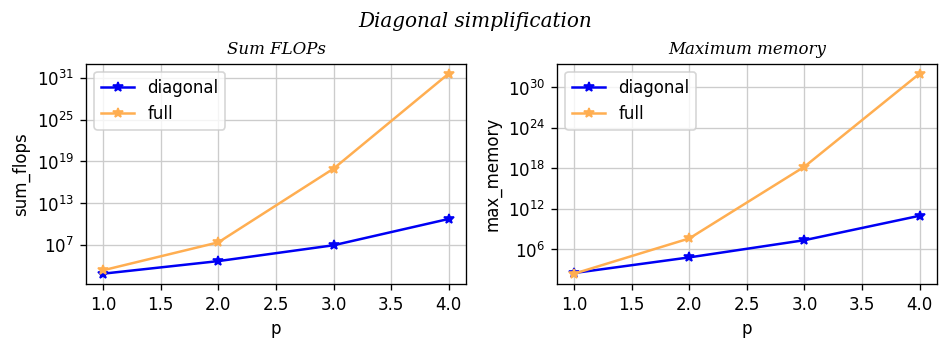

In [78]:
fig = ex.plot_variables2d(('sum_flops','max_memory'),
                          plot_kwargs=dict(marker='*'),
                          circuit_type=['energy'],
                          operators=['diagonal', 'full']
                          ,graph_type='grid'
                          ,p=[1,2,3,4]
                   ,seed=[100], d=[3], n=[200], composer_type='ZZ'
                   )
titles = (x for x in ('Energy expectation lightcone', 'Ansatz state'))
titles = (x for x in ('Sum FLOPs', 'Maximum memory'))
for ax in fig.axes:
    ax.grid(which='major', color='0.8')
    ax.grid(which='minor', color='0.8', alpha=.5)
    ax.set_title(next(titles), fontsize=10, fontfamily='serif', style='italic')
    ax.set_yscale('log')
    ax.legend(loc='upper left')
fig.suptitle('Diagonal simplification', fontfamily='serif', style='italic')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.set_dpi(120)
plt.savefig(plots_dir+'/diagonal_simplification_flops.pdf')

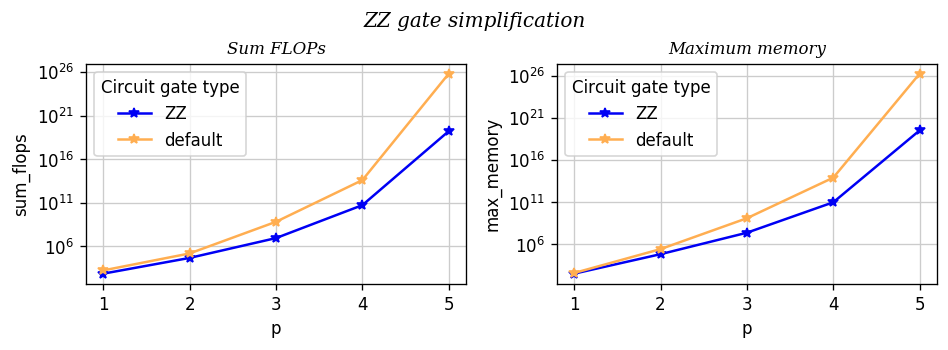

In [79]:
fig = ex.plot_variables2d(('sum_flops','max_memory'),
                          plot_kwargs=dict(marker='*'),
                          circuit_type=['energy']
                          ,composer_type=['ZZ', 'default']
                          ,p=[1,2,3,4,5]
                          ,graph_type=['grid']
                          ,n=[200]
                   ,seed=[100], d=[3], operators=['diagonal']
                   )

titles = (x for x in ('Energy expectation lightcone', 'Ansatz state'))
titles = (x for x in ('Sum FLOPs', 'Maximum memory'))
for ax in fig.axes:
    ax.grid(which='major', color='0.8')
    ax.grid(which='minor', color='0.8', alpha=.1)
    ax.set_title(next(titles), fontsize=10, fontfamily='serif', style='italic')
    ax.set_yscale('log')
    ax.legend(title='Circuit gate type', loc='upper left')
fig.suptitle('ZZ gate simplification', fontfamily='serif', style='italic')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.set_dpi(120)
fig.set_size_inches((8,3))
plt.savefig(plots_dir+'/zz_simplification_flops.pdf')

### Problem graph

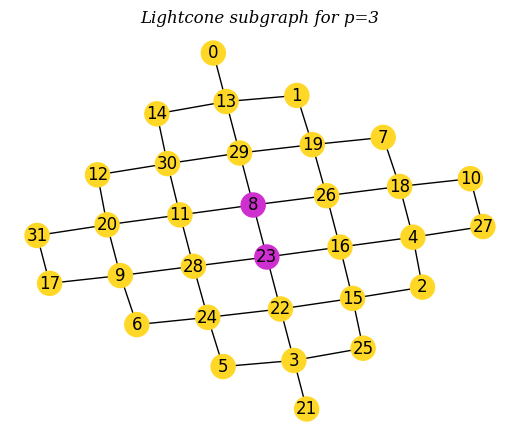

In [133]:
import matplotlib as mpl
blue = mpl.cm.get_cmap('gnuplot2')(.51)
yellow = mpl.cm.get_cmap('gnuplot2')(.84)

f = plt.figure(figsize=(5, 4), dpi=(100))
G = nx.grid_graph([10, 10], periodic=True)
p = 3
G = qt.utils.get_edge_subgraph(G, list(G.edges())[0], p)
G = nx.relabel_nodes(G, {n:i for i, n in enumerate(G.nodes)})
colors =  [blue if node in (8, 23) else yellow for node in G.nodes]

nx.draw_kamada_kawai(G, node_color=colors, with_labels=True)
#nx.draw_spring(G, node_color=colors, with_labels=True)
plt.title(f'Lightcone subgraph for p={p}', style='italic', fontfamily='serif')
plt.savefig(plots_dir+f'/lightcone_graph_p{p}.pdf')

### Line graph



nnodes 106
nnodes 242
nnodes 448


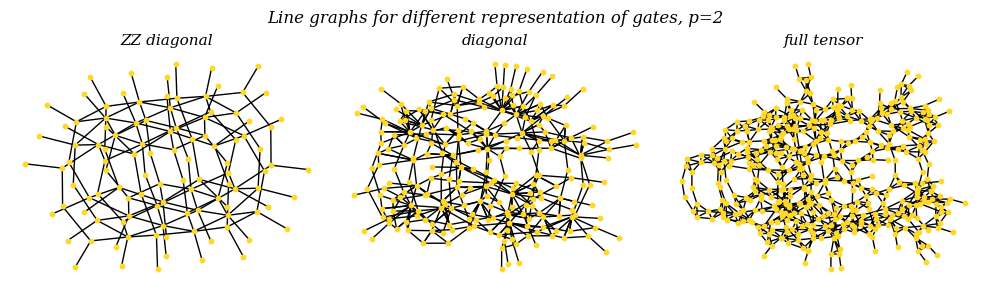

In [137]:
p=2
circuits = ex.map_variable('circuit', p=[p], composer_type=['ZZ', 'default']
                           , operators=['diagonal', 'full']
                           , n=[200]
                           , graph_type=['grid']
                           , circuit_type=['energy']
                   ,seed=[100], d=[3]
                   )

fig, axs = plt.subplots(1,3, figsize=(10, 3), dpi=100)
titles = iter(['ZZ diagonal', 'diagonal', 'full tensor'])
indices = iter([(0, 0), (1, 0), (1,1)])
for ax in axs:
    circuit = circuits[next(indices)]
    plt.sca(ax)
    
    tn = qt.optimisation.TensorNet.QtreeTensorNet.from_qtree_gates(circuit)
    g = tn.get_line_graph()
    nx.draw_kamada_kawai(g, node_color=[yellow], node_size=10)
    plt.title(next(titles), style='italic', fontfamily='serif', fontsize=11)
    print('nnodes', g.number_of_nodes())
    
plt.suptitle(f'Line graphs for different representation of gates, p={p}', style='italic', fontfamily='serif')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig(plots_dir+f'/lightcone_line_graph_p{p}.pdf')

### Problem graph

In [88]:
g.number_of_nodes()

212